## N.B. The meetup data is not the best example...

The meetup data is not the best example and the following simple models are not complicatd enough to fully demonstrate how well regularisation can be used in lasso and ridge regression. However, we will continue to demonstrate this before detailing how we can improve potentially upon our regression examples/dataset.


In [1]:
# import modules needed
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
# read in our data
data = pd.read_csv("clds.txt")
data.head(5)

,Date,Members,Meetup,Attendance,WeekDay,Comments,Days_Since_Meetup,Days_Till_Meetup
0,16910,1,NaN,NaN,NaN,NaN,0,0.0
1,16911,3,NaN,NaN,NaN,NaN,1,8.0
2,16914,43,NaN,NaN,NaN,NaN,4,5.0
3,16915,45,NaN,NaN,NaN,NaN,5,4.0
4,16916,90,NaN,NaN,NaN,NaN,6,3.0


## Simple Linear Regression

We will start with the most familiar linear regression, a straight-line fit to data.
A straight-line fit is a model of the form

$$
y = mx + b
$$

where $m$ is commonly known as the *gradient*, and $b$ is commonly known as the *intercept*.

We can use Scikit-Learn's ``LinearRegression`` estimator to fit this data and construct the best-fit line:

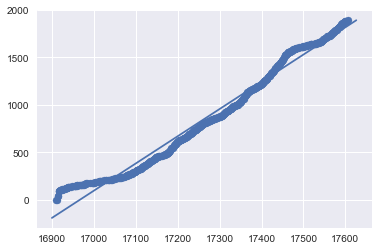

In [3]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
x = data.Date
y = data.Members
model.fit(x[:, np.newaxis], y)

xfit = np.linspace(16900, 17626, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

We can have a look at these parameters within the model object, with the relevant parameters being ``coef_`` and ``intercept_``:

In [4]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.8695912292
Model intercept: -48687.0850885


The ``LinearRegression`` estimator can also handle multidimensional linear models of the form

$$
y = b_0 + m_1x_1 + m_2x_2 + ... + m_nx_n
$$

where there are multiple $x$ values.

These are often referred to as general linear models (GLMs). In more general GLM modelling, each term that appears before an input variable are referred to as coefficients. For example in:

$$
y = b + m_1x_1 + m_2x_2 + ... + m_nx_n
$$

The coefficients are:

$$
coef = (m_1, m_2, ... m_n)
$$


Linear regression in its most basic form is carried out by minimising the **residual sum of squares (RSS)**, i.e. the error between the observed responses in the dataset, and the responses predicted by the linear approximation. This is known as **ordinary least squares (OLS)**. OLS is good for simple examples, though as we will see it can lead to overfitting of more complex models, for example when we attempt to use basic linear regression for high multidimensional data.

---

## Altering our Function's Basis

One way to make our linear regression more powerful would be to transform the input data so that it can better model non-linear relationships, such as out meetup data.

The idea is to take our multidimensional linear model:
$$
y = b_0 + m_1x_1 + m_2x_2 + ... + m_nx_n
$$

and build the $x_1, x_2, x_3,$ and so on, from our single-dimensional input $x$. So in our case this is the Meetup data's Date variable. In this way we can use just the date information to better fit the meetup numbers. 

For example, if $f_n(x) = x^n$, our model becomes a polynomial regression:

$$
y = b_0 + m_1x + m_2x^2 + ... + m_nx^n
$$


### Polynomial basis functions

This polynomial projection is in Scikit-Learn and can be used with the ``PolynomialFeatures`` transformer:

In [5]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[  2.,   4.,   8.],
       [  3.,   9.,  27.],
       [  4.,  16.,  64.]])

Ther transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value, specified by the first argument to *PolynomialFeatures*.

This new, higher-dimensional data representation can then be plugged into a linear regression.

In [6]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(5),
                           LinearRegression())

With this transform in place, we can use the linear model to fit to our meetup data.

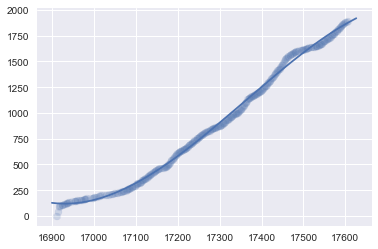

In [7]:
rng = np.random.RandomState(1)
x = np.array(data.Date)
y = np.array(data.Members)

xfit = np.linspace(16900, 17626, 1000)
poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y,alpha=.1)
plt.plot(xfit, yfit);

## Linear regression with and without regularisation

Regularisation is a method to improve upon some of the potential flaws in our basic OLS method. Two popular methods are **ridge regression** and **lasso regression**. These two methods work by imposing penalites on the size of the coefficients.

Lasso regression penalises the sum of the coefficients (known as L1 regularisation), by attempting to minimise the following:

$$
RSS + \alpha.\Sigma(Coefficients)
$$

and ridge regression penalises the sum of the square of the coefficients (known as L2 regularisation), and thus attempts to minimise the following:

$$
RSS + \alpha.\Sigma(Coefficients^2)
$$

with $\alpha$ here controlling the strength of penalisation.

These 2 techniques have different properties in how they select for different model complexities. For a better example and full descriptuion of this head [here](https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/).

---
We are now going to have a look at how to implement these, and compare the performance of these two methods for our meetup data

In [8]:
## Global variables for our programs
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline

ridge_alpha = tuple([10**(x) for x in range(-3,0,1) ]) # Alpha (regularization strength) of ridge regression
lasso_eps = 0.001
lasso_nalpha=20
lasso_iter=100000
degree_min=2
degree_max=10

C:\Users\Oliver\Anaconda3\envs\regression2000\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(data['Date'], data['Members'], test_size=0.33)
X_train=X_train.values.reshape(-1,1)
X_test=X_test.values.reshape(-1,1)

Test score of model with degree 2: 0.9899776869925747

Test score of model with degree 3: 0.9963202280928103

Test score of model with degree 4: 0.9966163964100814

Test score of model with degree 5: 0.9965788477738597

Test score of model with degree 6: 0.9964818414716783

Test score of model with degree 7: 0.9983222448944926

Test score of model with degree 8: 0.9982832161165229

Test score of model with degree 9: 0.9985223750483692

Test score of model with degree 10: 0.9985392371020574



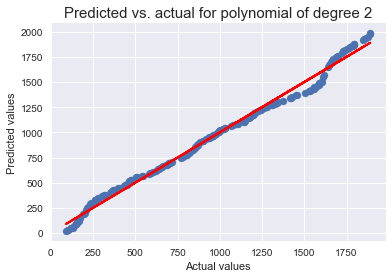

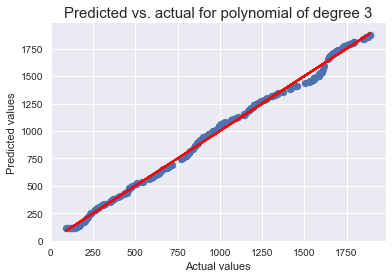

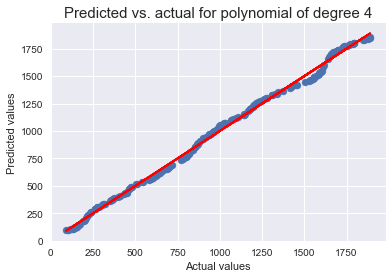

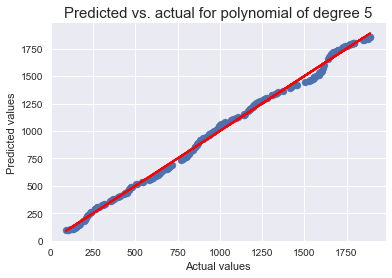

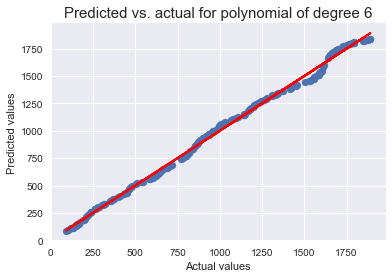

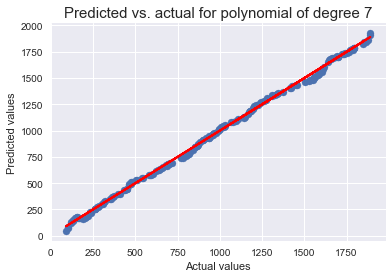

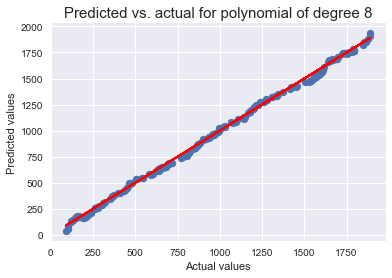

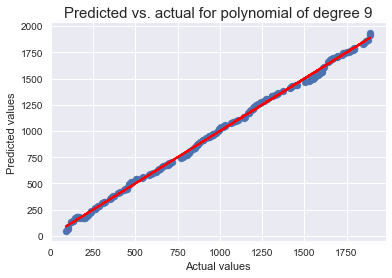

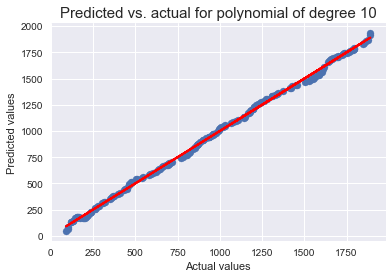

In [10]:
# No regularisation

no_regularisation_sample_score = []
poly_degree = []
for degree in range(2,10+1):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression(normalize=True))
    
    model.fit(X_train, y_train)
    y_pred = np.array(model.predict(X_train))
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(y_pred-y_train)))
    test_score = model.score(X_test,y_test)
    no_regularisation_sample_score.append(test_score)
    poly_degree.append(degree)
    print("Test score of model with degree {}: {}\n".format(degree,test_score))

    plt.figure()
    plt.title("Predicted vs. actual for polynomial of degree {}".format(degree),fontsize=15)
    plt.xlabel("Actual values")
    plt.ylabel("Predicted values")
    plt.scatter(y_test,test_pred)
    plt.plot(y_test,y_test,'r',lw=2)

In [120]:
no_regularisation_sample_score

[0.99111750082450745,
 0.99710722096218329,
 0.99735201819474506,
 0.99733899842822393,
 0.99732054239727963,
 0.99852066335498024,
 0.99882326243846575,
 0.99898800614504968,
 0.99900166513145705]

We can see here that in the no regularisation method, when we increase the degree of the polynomial basis conversion that the model score improves.

---

Now onto the lasso...

Test score of model with degree 2: 0.9761394043283046

Test score of model with degree 3: 0.9774769730173415

Test score of model with degree 4: 0.9787454179445112

Test score of model with degree 5: 0.9807731783268325

Test score of model with degree 6: 0.9845390174360856

Test score of model with degree 7: 0.9865569913780533

Test score of model with degree 8: 0.9875750407842633

Test score of model with degree 9: 0.9882001965479944

Test score of model with degree 10: 0.9886163005594661



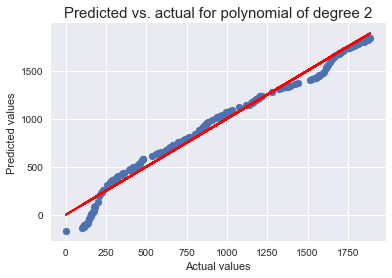

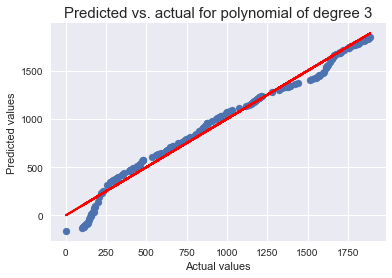

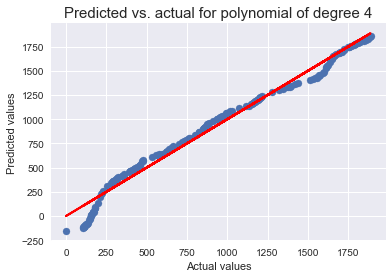

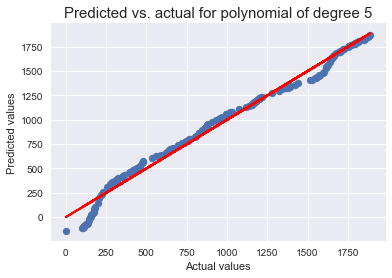

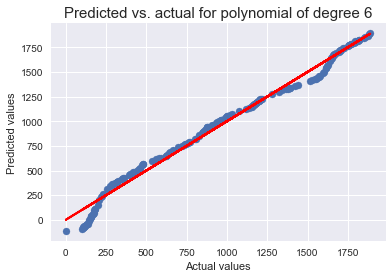

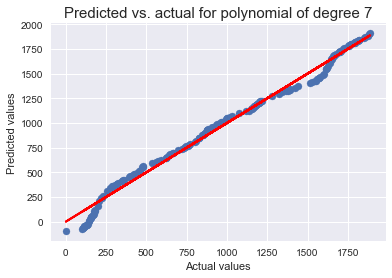

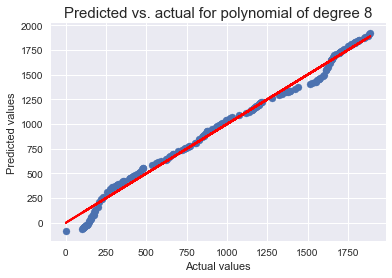

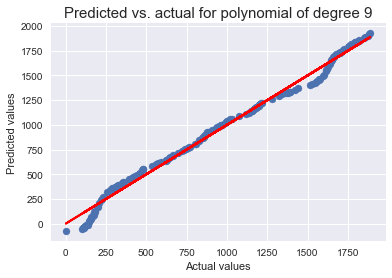

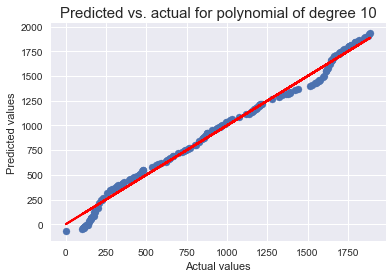

In [124]:
# lasso 

lass_sample_score = []
poly_degree = []
for degree in range(2,10+1):
   
    model = make_pipeline(PolynomialFeatures(degree), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha, 
                                                                  max_iter=lasso_iter,normalize=True,cv=5))
    model.fit(X_train, y_train)
    y_pred = np.array(model.predict(X_train))
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(y_pred-y_train)))
    test_score = model.score(X_test,y_test)
    lass_sample_score.append(test_score)
    poly_degree.append(degree)
    print("Test score of model with degree {}: {}\n".format(degree,test_score))
    
    plt.figure()
    plt.title("Predicted vs. actual for polynomial of degree {}".format(degree),fontsize=15)
    plt.xlabel("Actual values")
    plt.ylabel("Predicted values")
    plt.scatter(y_test,test_pred)
    plt.plot(y_test,y_test,'r',lw=2)


---

And onto the ridge...

Test score of model with degree 2: 0.9758362704648843

Test score of model with degree 3: 0.9776684688186358

Test score of model with degree 4: 0.9801148963311862

Test score of model with degree 5: 0.9827802441341431

Test score of model with degree 6: 0.9851957489241788

Test score of model with degree 7: 0.9870762229296489

Test score of model with degree 8: 0.9883800759966361

Test score of model with degree 9: 0.9892115615356384

Test score of model with degree 10: 0.9897102975664087



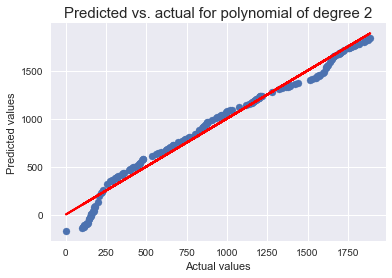

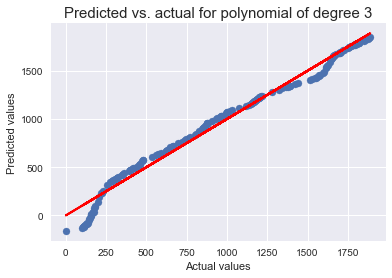

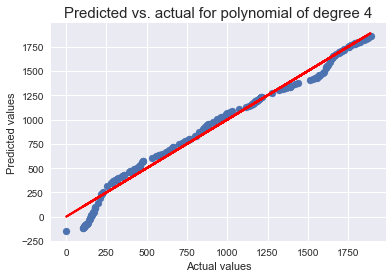

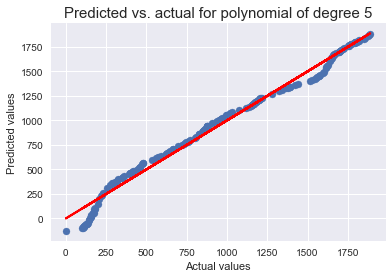

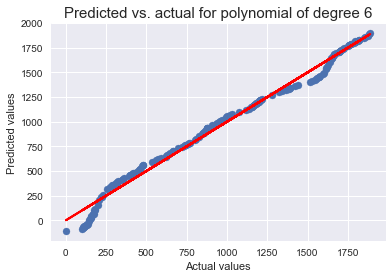

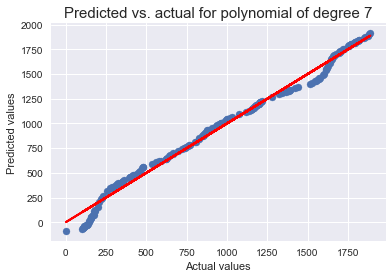

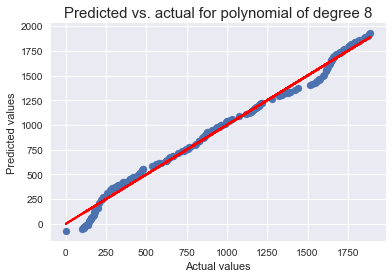

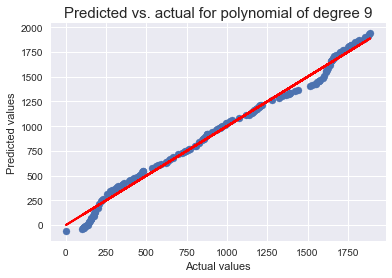

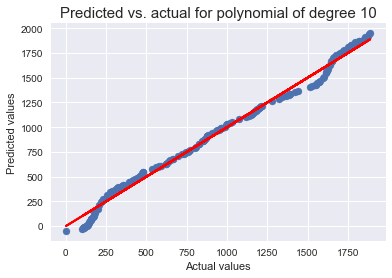

In [125]:
#ridge

ridge_sample_score = []
poly_degree = []
for degree in range(2,10+1):
    model = make_pipeline(PolynomialFeatures(degree), RidgeCV(alphas=ridge_alpha,normalize=True,cv=5))
    model.fit(X_train, y_train)
    y_pred = np.array(model.predict(X_train))
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(y_pred-y_train)))
    test_score = model.score(X_test,y_test)
    ridge_sample_score.append(test_score)
    poly_degree.append(degree)
    print("Test score of model with degree {}: {}\n".format(degree,test_score))

    
    plt.figure()
    plt.title("Predicted vs. actual for polynomial of degree {}".format(degree),fontsize=15)
    plt.xlabel("Actual values")
    plt.ylabel("Predicted values")
    plt.scatter(y_test,test_pred)
    plt.plot(y_test,y_test,'r',lw=2)

---

And let's have a look at the improvement for these scores as we have increased our polynomial

In [126]:
df_score = pd.DataFrame(data={'degree':[d for d in range(degree_min,degree_max+1)],
                              'No Regularisation':no_regularisation_sample_score,
                              'Ridge sample score':ridge_sample_score,
                             'Lasso sample score':lass_sample_score})
df_score

,Lasso sample score,No Regularisation,Ridge sample score,degree
0,0.976139,0.991118,0.975836,2
1,0.977477,0.997107,0.977668,3
2,0.978745,0.997352,0.980115,4
3,0.980773,0.997339,0.982780,5
4,0.984539,0.997321,0.985196,6
5,0.986557,0.998521,0.987076,7
6,0.987575,0.998823,0.988380,8
7,0.988200,0.998988,0.989212,9
8,0.988616,0.999002,0.989710,10


So the normal OLS works just fine! But this is mostly becuase our model is still very simple and the use of just the polynomial basis transformation does not introduce enough model complexity to make the OLS overfit. 

---

For a better example and descriptions of how these methods can be used, I would recommend the Linear regression notebook in this same directory, which is taken from the [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook). Or if you would like to see another tutorial with a simpler set of data that demonstrates these advantages, then have a look at this [tutorial](https://towardsdatascience.com/machine-learning-with-python-easy-and-robust-method-to-fit-nonlinear-data-19e8a1ddbd49)

---

## Take home challenge

I have included in the CLDS dataset a lot of extra data that is not being used. Perhaps this could be used to construct additional features that could make more predictive models. For example think about extracting the topic of the meetup. 